In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT) #이미지 크기
IMAGE_CHANNELS=3 #RGB 세 가지 색상을 의미

In [3]:
train_dir = os.listdir('./train')
categories = []
for file_name in train_dir:
  category = file_name.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename' : train_dir,
    'category' : categories
})

print(df.head())
print(df.tail())

        filename  category
0  cat.11082.jpg         0
1   dog.5552.jpg         1
2   dog.8682.jpg         1
3   cat.5615.jpg         0
4  cat.10775.jpg         0
            filename  category
24995  dog.11232.jpg         1
24996   dog.8702.jpg         1
24997   cat.4508.jpg         0
24998  cat.11314.jpg         0
24999   cat.1291.jpg         0


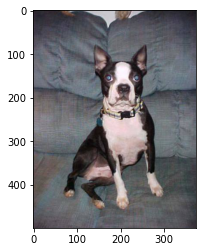

In [4]:
sample = random.choice(train_dir)
image = load_img('./train/'+sample)
plt.imshow(image)

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D , Dropout , Flatten, Dense, Activation, BatchNormalization

model = Sequential()

#padding은 기본으로 'valid'으로 설정되어 있다. 즉, 크기가 줄어 드는 것
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [6]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

callbacks = [earlystop, learning_rate_reduction]

In [7]:
# 0 과 1을 cat과 dog로 변환. 나중에 이유가 나옴
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

# train 과 validate를 나눔
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True) #데이터 프레임 내에서 인덱스만들기
validate_df = validate_df.reset_index(drop=True) 

print(train_df,validate_df)

#shape[0]은 행의 개수임 why? 2차원 리스트의 shape는 (행,열) 형태의 튜플로 반환되기 때문
total_train = train_df.shape[0] # train 데이터의 총 갯수
total_validate = validate_df.shape[0] # validate 데이터의 총 갯수
batch_size=15 # 배치 사이즈

            filename category
0      cat.10174.jpg      cat
1       dog.3011.jpg      dog
2       dog.8766.jpg      dog
3       dog.3961.jpg      dog
4       cat.6174.jpg      cat
...              ...      ...
19995   dog.2447.jpg      dog
19996   dog.9901.jpg      dog
19997   dog.4316.jpg      dog
19998   cat.7924.jpg      cat
19999   cat.8487.jpg      cat

[20000 rows x 2 columns]            filename category
0      dog.2124.jpg      dog
1      cat.1033.jpg      cat
2     dog.10561.jpg      dog
3      dog.2462.jpg      dog
4     dog.10782.jpg      dog
...             ...      ...
4995   cat.5465.jpg      cat
4996   cat.5032.jpg      cat
4997   cat.4829.jpg      cat
4998   cat.5937.jpg      cat
4999   cat.5358.jpg      cat

[5000 rows x 2 columns]


<AxesSubplot:>

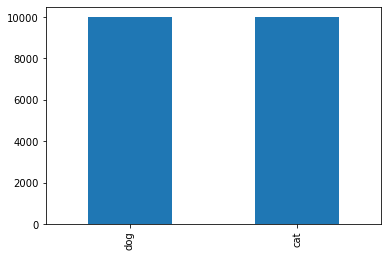

In [8]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

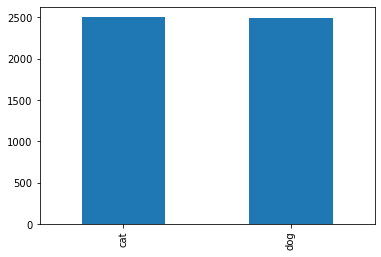

In [9]:
validate_df['category'].value_counts().plot.bar()

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical', #categorical모드를 사용하기 위해 위에서 0과 1을 cat과 dog로 변환시켰다
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


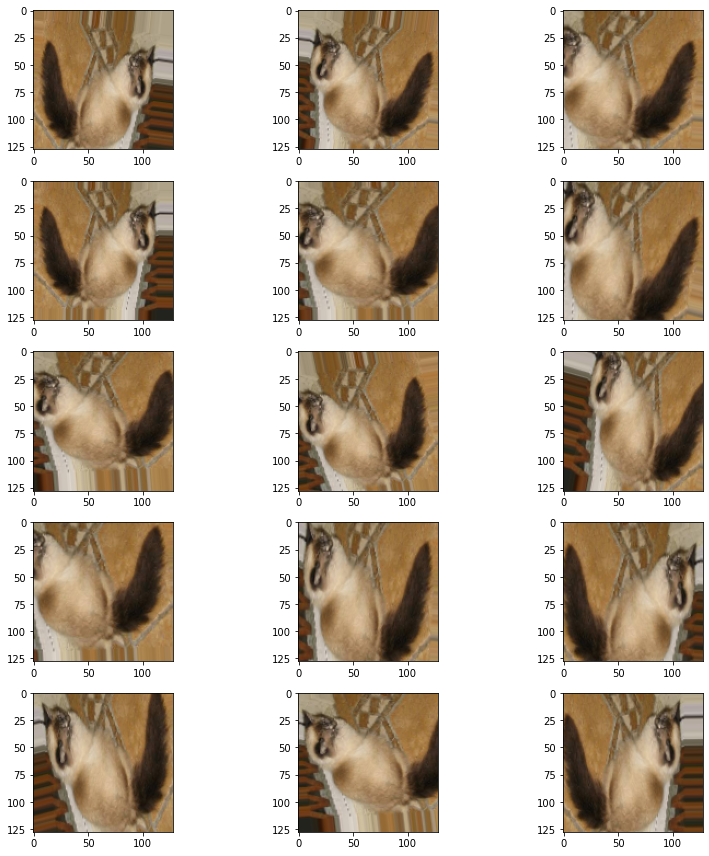

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [21]:
epochs=3 if FAST_RUN else 50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size, #검증 데이터를 일정 비율로 나눠서 메모리로
    steps_per_epoch=total_train//batch_size, # 매 epoch 마다 일정 비율로 나눠서 메모리로
    callbacks=callbacks,
)

Epoch 1/3
1333/1333 [==============================] - 144s 108ms/step - loss: 0.6998 - accuracy: 0.6571 - val_loss: 0.6053 - val_accuracy: 0.6773 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 144s 108ms/step - loss: 0.5460 - accuracy: 0.7336 - val_loss: 0.4826 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 145s 109ms/step - loss: 0.4905 - accuracy: 0.7715 - val_loss: 0.4967 - val_accuracy: 0.7692 - lr: 0.0010


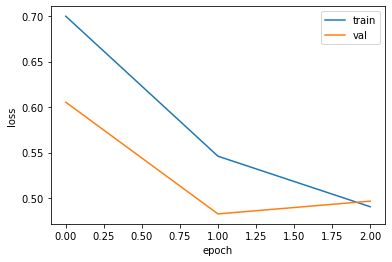

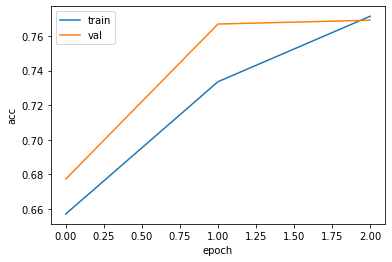

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

In [23]:
test_dir = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename': test_dir
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [24]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))
print(predict)

[[0.00667289 0.99332714]
 [0.8734208  0.12657927]
 [0.2898585  0.71014154]
 ...
 [0.1494866  0.85051346]
 [0.31262466 0.68737537]
 [0.30702716 0.69297284]]


In [25]:
test_df['category'] = np.argmax(predict, axis=-1) # 정답이라고 예측하는 것을 택함
print(test_df.head())

    filename  category
0   3470.jpg         1
1   1451.jpg         0
2  11804.jpg         1
3  11487.jpg         1
4  11036.jpg         1


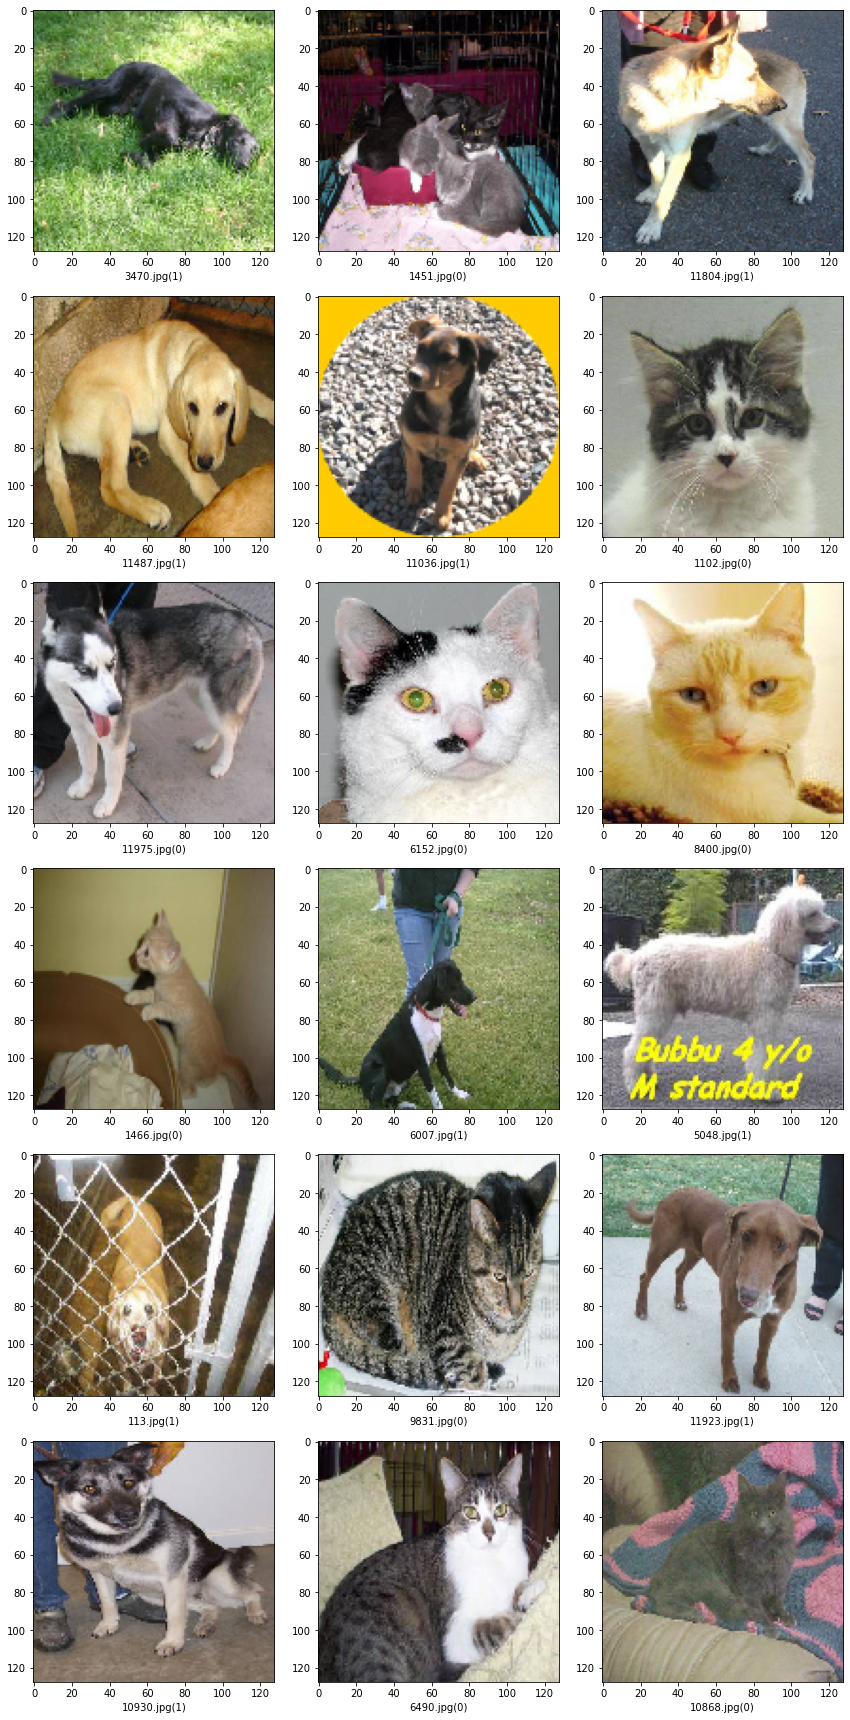

In [26]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()